In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow

In [3]:
import json
import math
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import cv2
from PIL import Image
import numpy as np
from keras import layers
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

In [4]:

for dirname, _, filenames in os.walk('/content/drive/MyDrive/breastData'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

/content/drive/MyDrive/breastData/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-003.png
/content/drive/MyDrive/breastData/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-004.png
/content/drive/MyDrive/breastData/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-001.png
/content/drive/MyDrive/breastData/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-011.png
/content/drive/MyDrive/breastData/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-015.png
/content/drive/MyDrive/breastData/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-005.png
/content/drive/MyDrive/breastData/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-007.png
/content/drive/MyDrive/breastData/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-019.png
/content/drive/MyDrive/breastData/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-025.png
/content/drive/MyDrive/breastData/BreaKHis 400X/test/benign/SOB_B_F-14-14134-400-024.png
/content/drive/MyDrive/breastData/BreaKHis 400X/test/benign/SOB_B_A-14-22549G-400-007.png
/c

In [5]:
benign_train = np.array(Dataset_loader('/content/drive/MyDrive/breastData/BreaKHis 400X/train/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/breastData/BreaKHis 400X/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/breastData/BreaKHis 400X/test/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/breastData/BreaKHis 400X/test/malignant',224))
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

X_train_Normalized = X_train / 255.0
X_test_Normalized = X_test / 255.0

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)
x_train, x_val, y_train, y_val = train_test_split(
    X_train_Normalized, Y_train,
    test_size=0.2,
    random_state=11
)


100%|██████████| 369/369 [00:09<00:00, 39.21it/s]


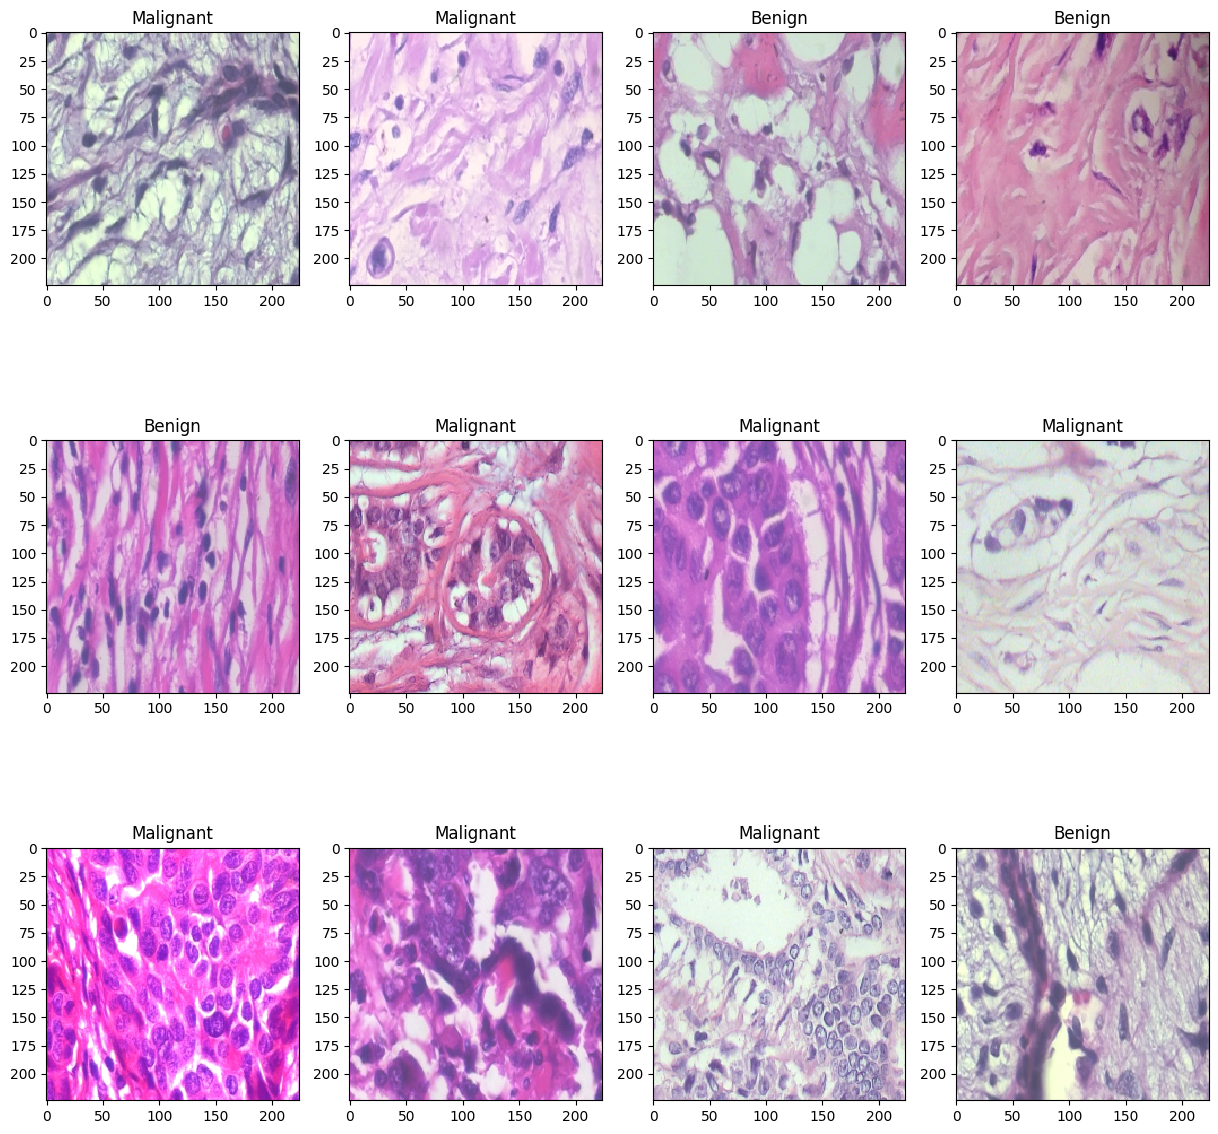

In [6]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')



In [7]:
X_train.shape

(1148, 224, 224, 3)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))  # Binary classification output

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
K.clear_session()
gc.collect()


29580

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import numpy as np
from sklearn.metrics import accuracy_score

# ... Your code up to the model definition ...

def learning_rate_scheduler(epoch):
    # Start with a higher learning rate and gradually decrease it during training
    initial_lr = 1e-4
    decay_factor = 0.9
    new_lr = initial_lr * (decay_factor ** epoch)
    return new_lr

# Data Augmentation
train_generator = ImageDataGenerator(
    zoom_range=2,           # Set range for random zoom
    rotation_range=90,       # Set range for random rotation
    horizontal_flip=True,    # Randomly flip images horizontally
    vertical_flip=True       # Randomly flip images vertically
)

# Model Training
BATCH_SIZE = 32
EPOCHS = 30

# Add EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model Checkpoint to save the best model during training
filepath = '/content/drive/MyDrive/ModelBreast_CNN'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Learning Rate Scheduler callback
lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

# Fit the model
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

# Load best model weights
model.load_weights(filepath)

# Evaluate the model
Y_val_pred = model.predict(x_val)
accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
model.save("/content/drive/MyDrive/ModelBreast_CNN/model_CNN.h5")


<ipython-input-16-c3fc192d003c>:37: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
28/28 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.6445
Epoch 1: val_accuracy improved from -inf to 0.68696, saving model to /content/drive/MyDrive/ModelBreast_CNN


28/28 [==============================] - 97s 3s/step - loss: 0.6962 - accuracy: 0.6445 - val_loss: 0.6614 - val_accuracy: 0.6870 - lr: 1.0000e-04
Epoch 2/30
28/28 [==============================] - ETA: 0s - loss: 0.6202 - accuracy: 0.6738
Epoch 2: val_accuracy did not improve from 0.68696
28/28 [==============================] - 16s 560ms/step - loss: 0.6202 - accuracy: 0.6738 - val_loss: 0.6110 - val_accuracy: 0.6870 - lr: 9.0000e-05
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 0.5770 - accuracy: 0.6693
Epoch 3: val_accuracy improved from 0.68696 to 0.79130, saving model to /content/drive/MyDrive/ModelBreast_CNN


28/28 [==============================] - 143s 5s/step - loss: 0.5770 - accuracy: 0.6693 - val_loss: 0.5289 - val_accuracy: 0.7913 - lr: 8.1000e-05
Epoch 4/30
28/28 [==============================] - ETA: 0s - loss: 0.5157 - accuracy: 0.7540
Epoch 4: val_accuracy improved from 0.79130 to 0.85652, saving model to /content/drive/MyDrive/ModelBreast_CNN


28/28 [==============================] - 316s 12s/step - loss: 0.5157 - accuracy: 0.7540 - val_loss: 0.4931 - val_accuracy: 0.8565 - lr: 7.2900e-05
Epoch 5/30
28/28 [==============================] - ETA: 0s - loss: 0.5179 - accuracy: 0.7404
Epoch 5: val_accuracy did not improve from 0.85652
28/28 [==============================] - 16s 524ms/step - loss: 0.5179 - accuracy: 0.7404 - val_loss: 0.5026 - val_accuracy: 0.8522 - lr: 6.5610e-05
Epoch 6/30
28/28 [==============================] - ETA: 0s - loss: 0.4909 - accuracy: 0.7958
Epoch 6: val_accuracy did not improve from 0.85652
28/28 [==============================] - 13s 479ms/step - loss: 0.4909 - accuracy: 0.7958 - val_loss: 0.4710 - val_accuracy: 0.8261 - lr: 5.9049e-05
Epoch 7/30
28/28 [==============================] - ETA: 0s - loss: 0.4723 - accuracy: 0.8352
Epoch 7: val_accuracy improved from 0.85652 to 0.86957, saving model to /content/drive/MyDrive/ModelBreast_CNN


28/28 [==============================] - 1013s 37s/step - loss: 0.4723 - accuracy: 0.8352 - val_loss: 0.4722 - val_accuracy: 0.8696 - lr: 5.3144e-05
Epoch 8/30
28/28 [==============================] - ETA: 0s - loss: 0.4561 - accuracy: 0.8251
Epoch 8: val_accuracy did not improve from 0.86957
28/28 [==============================] - 15s 486ms/step - loss: 0.4561 - accuracy: 0.8251 - val_loss: 0.4677 - val_accuracy: 0.8174 - lr: 4.7830e-05
Epoch 9/30
28/28 [==============================] - ETA: 0s - loss: 0.4503 - accuracy: 0.8363
Epoch 9: val_accuracy did not improve from 0.86957
28/28 [==============================] - 14s 484ms/step - loss: 0.4503 - accuracy: 0.8363 - val_loss: 0.4712 - val_accuracy: 0.8609 - lr: 4.3047e-05
Epoch 10/30
28/28 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.8318
Epoch 10: val_accuracy did not improve from 0.86957
28/28 [==============================] - 13s 433ms/step - loss: 0.4444 - accuracy: 0.8318 - val_loss: 0.4705 - val_a

<Axes: >

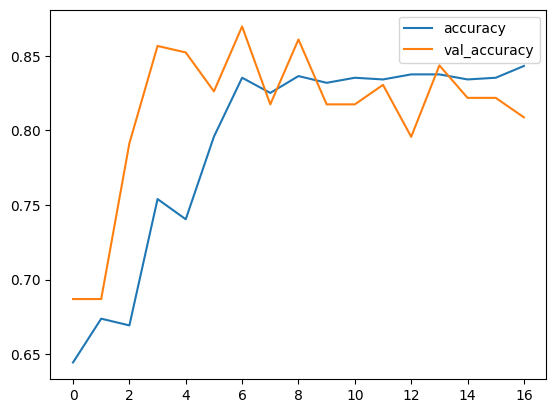

In [17]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()